<a href="https://colab.research.google.com/github/SatioO/DL_Practices/blob/master/PSPNET_with_tf2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q git+https://github.com/tensorflow/examples.git
!pip install -q -U tfds-nightly

     |████████████████████████████████| 3.3MB 4.8MB/s 


In [0]:
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from math import ceil
import matplotlib.pyplot as plt
from IPython.display import clear_output
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [3]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompletePECO23/oxford_iiit_pet-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompletePECO23/oxford_iiit_pet-test.tfrecord
Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [0]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask


@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (240, 240))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (240, 240))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (240, 240))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (240, 240))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 100
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)


train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
test_dataset = test.batch(BATCH_SIZE)

In [0]:
def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2), dilation=1):
  # A block that has a conv layer at shortcut.
  filter1, filter2, filter3 = filters
  
  conv_name_base = 'res' + str(stage) + block + '_branch'
  bn_name_base = 'bn' + str(stage) + block + '_branch'

  strides = (1, 1) if dilation > 1 else strides

  x = layers.Conv2D(filter1, (1, 1), strides=strides, name=conv_name_base + '2a')(input_tensor)
  x = layers.BatchNormalization(name=bn_name_base + '2a')(x)
  x = layers.Activation('relu')(x)

  x = layers.Conv2D(filter2, kernel_size, padding='same', name=conv_name_base + '2b', dilation_rate=dilation)(x)
  x = layers.BatchNormalization(name=bn_name_base + '2b')(x)
  x = layers.Activation('relu')(x)

  x = layers.Conv2D(filter3, (1, 1), name=conv_name_base + '2c')(x)
  x = layers.BatchNormalization(name=bn_name_base + '2c')(x)

  shortcut = layers.Conv2D(filter3, (1, 1), strides=strides, name=conv_name_base + '1')(input_tensor)
  shortcut = layers.BatchNormalization(name=bn_name_base + '1')(shortcut)

  x = layers.add([x, shortcut])
  x = layers.Activation('relu')(x)

  return x

def identity_block(input_tensor, kernel_size, filters, stage, block, dilation=1):
  # The identity block is the block that has no conv layer at shortcut.
  filter1, filter2, filter3 = filters

  conv_name_base = 'res' + str(stage) + block + '_branch'
  bn_name_base = 'bn' + str(stage) + block + '_branch'

  x = layers.Conv2D(filter1, (1, 1), name=conv_name_base + '2a')(input_tensor)
  x = layers.BatchNormalization(name=bn_name_base + '2a', momentum=0.95, epsilon=1e-5)(x)
  x = layers.Activation('relu')(x)

  x = layers.Conv2D(filter2, kernel_size, padding='same', name=conv_name_base + '2b', dilation_rate=dilation)(x)
  x = layers.BatchNormalization(name=bn_name_base + '2b', momentum=0.95, epsilon=1e-5)(x)
  x = layers.Activation('relu')(x)

  x = layers.Conv2D(filter3, (1, 1), name=conv_name_base + '2c')(x)
  x = layers.BatchNormalization(name=bn_name_base + '2c', momentum=0.95, epsilon=1e-5)(x)
  x = layers.add([x, input_tensor])
  x = layers.Activation('relu')(x)

  return x


def resnet50(img_input):
  x = layers.ZeroPadding2D((3, 3), name='conv1_pad')(img_input)
  x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='valid', kernel_initializer='he_normal', name='conv1')(x)
  x = layers.BatchNormalization(name='bn_conv1', momentum=0.95, epsilon=1e-5)(x)
  x = layers.Activation('relu')(x)
  x = layers.ZeroPadding2D((1, 1), name='pool1_pad')(x)
  x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)
  f1 = x

  x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
  x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
  x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')
  f2 = x

  x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
  x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
  x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
  x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')
  f3 = x

  x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a', dilation=2)
  x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b', dilation=2)
  x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c', dilation=2)
  x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d', dilation=2)
  x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e', dilation=2)
  x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f', dilation=2)
  f4 = x

  x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a', dilation=4)
  x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b', dilation=4)
  x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c', dilation=4)
  f5 = x

  return [f1, f2, f3, f4, f5]

In [0]:
class Interp(layers.Layer):
    def __init__(self, new_size, **kwargs):
        self.new_size = new_size
        super(Interp, self).__init__(**kwargs)

    def build(self, input_shape):
        super(Interp, self).build(input_shape)

    def call(self, inputs, **kwargs):
        new_height, new_width, _ = self.new_size
        try:
            resized = tf.image.resize(inputs, [new_height, new_width])
        except AttributeError:
            resized = tf.image.resize(inputs, [new_height, new_width],
                                             align_corners=True)
        return resized

    def compute_output_shape(self, input_shape):
        return tuple([None,
                      self.new_size[0],
                      self.new_size[1],
                      input_shape[3]])

    def get_config(self):
        config = super(Interp, self).get_config()
        config['new_size'] = self.new_size
        return config

def interp_block(prev_layer, level, feature_map_shape, input_shape):
  kernel_strides_map = {1: 30,
                        2: 15,
                        3: 10,
                        6: 5}

  names = [
      "conv5_3_pool" + str(level) + "_conv",
      "conv5_3_pool" + str(level) + "_conv_bn"
  ]

  kernel = (kernel_strides_map[level], kernel_strides_map[level])
  strides = (kernel_strides_map[level], kernel_strides_map[level])

  prev_layer = layers.AveragePooling2D(kernel, strides=strides)(prev_layer)
  prev_layer = layers.Conv2D(512, (1, 1), strides=(1, 1), name=names[0], use_bias=False)(prev_layer)
  prev_layer = layers.BatchNormalization(name=names[1])(prev_layer)
  prev_layer = layers.Activation('relu')(prev_layer)
  prev_layer = Interp(feature_map_shape)(prev_layer)

  return prev_layer

def build_pyramid_pooling_module(res, input_shape):
  feature_map_size = tuple(int(ceil(input_dim / 8.0))
                             for input_dim in input_shape)
  
  interp_block1 = interp_block(res, 1, feature_map_size, input_shape)
  interp_block2 = interp_block(res, 2, feature_map_size, input_shape)
  interp_block3 = interp_block(res, 3, feature_map_size, input_shape)
  interp_block6 = interp_block(res, 6, feature_map_size, input_shape)

  res = layers.Concatenate()([res,
                        interp_block6,
                        interp_block3,
                        interp_block2,
                        interp_block1])
  
  return res
  

def pspnet(input_shape, num_classes):
  img_input = keras.layers.Input(input_shape)

  [f1, f2, f3, f4, f5] = resnet50(img_input)

  psp = build_pyramid_pooling_module(f5, input_shape)

  x = layers.Conv2D(512, 3, strides=1, padding='same')(psp)
  x = layers.BatchNormalization(momentum=0.95, epsilon=1e-5)(x)
  x = layers.ReLU()(x)
  x = layers.Dropout(0.1)(x)

  x = layers.Conv2D(num_classes, 1, strides=1)(x)

  outputs = Interp(input_shape)(x)
  
  return keras.Model(img_input, outputs)

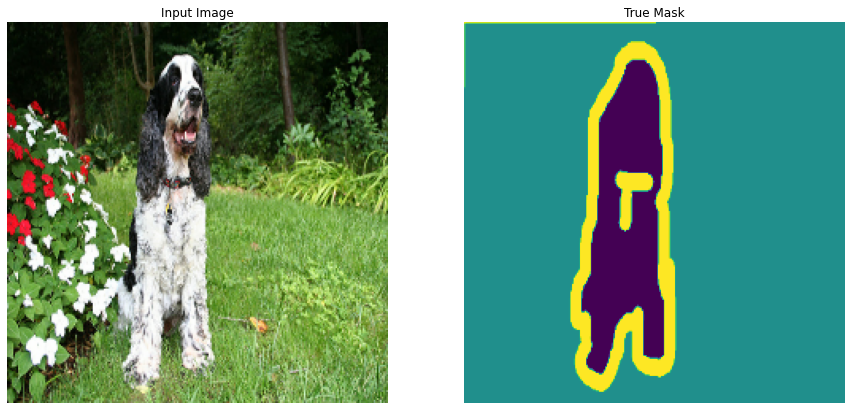

In [37]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

for image, mask in train.take(2):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [0]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

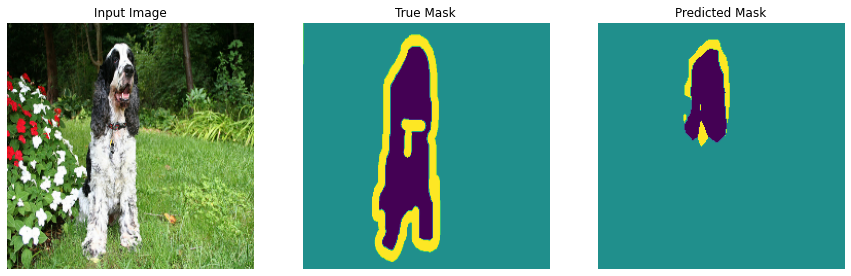


Sample Prediction after epoch 17

115/115 [==============================] - 102s 890ms/step - accuracy: 0.9062 - loss: 0.2194 - val_accuracy: 0.8677 - val_loss: 0.3444
Epoch 18/100
  4/115 [>.............................] - ETA: 1:10 - accuracy: 0.9078 - loss: 0.2210

In [0]:
strategy = tf.distribute.MirroredStrategy()

EPOCHS = 100
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS


with strategy.scope():
  model = pspnet((240, 240, 3), 3)
  model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

  model_history = model.fit(train_dataset, 
                            epochs=EPOCHS,
                            lr_schedule=keras.optimizers.schedules.PolynomialDecay(1e-3,decay_steps=STEPS_PER_EPOCH,decay_rate=0.96, staircase=True),
                            steps_per_epoch=STEPS_PER_EPOCH,
                            validation_steps=VALIDATION_STEPS,
                            validation_data=test_dataset,
                            callbacks=[DisplayCallback()])

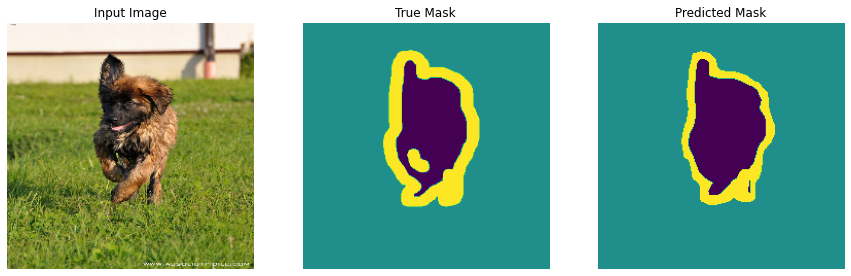

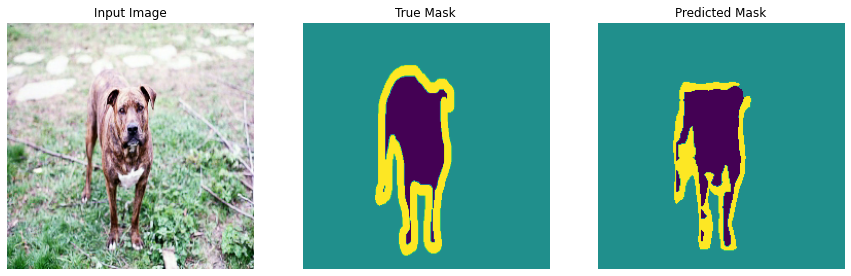

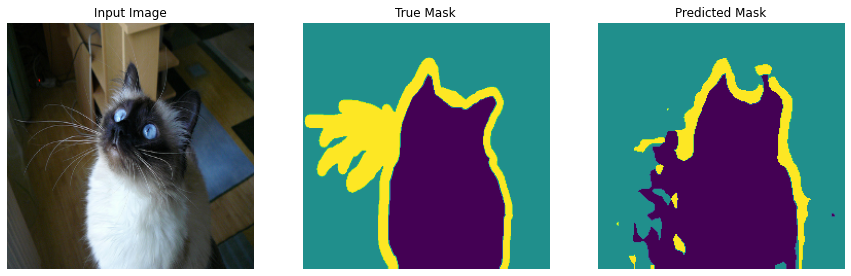

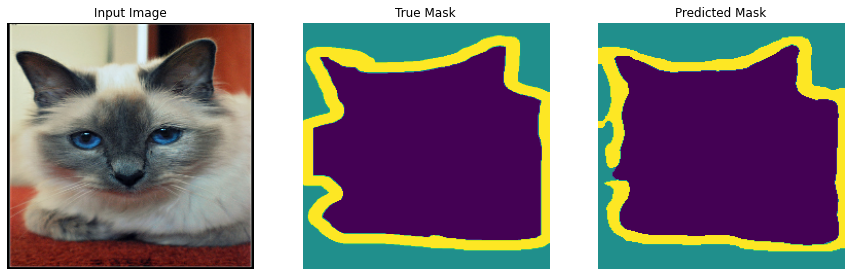

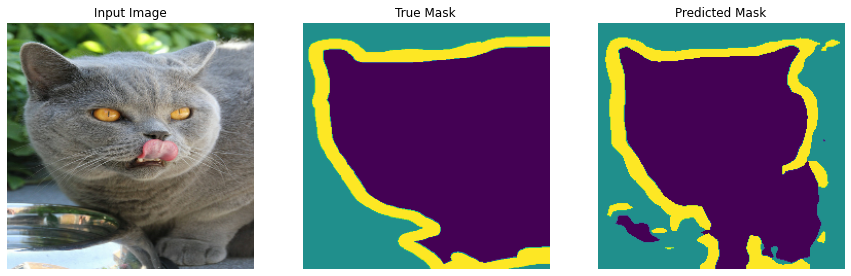

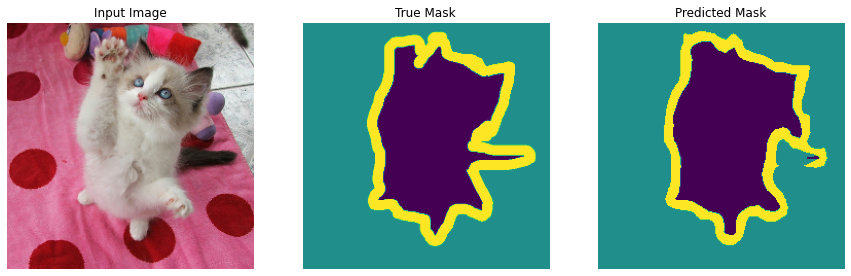

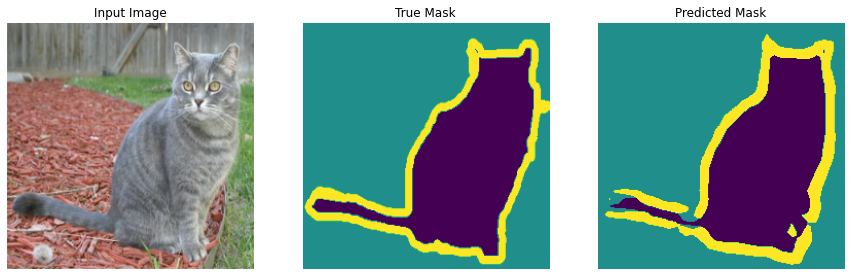

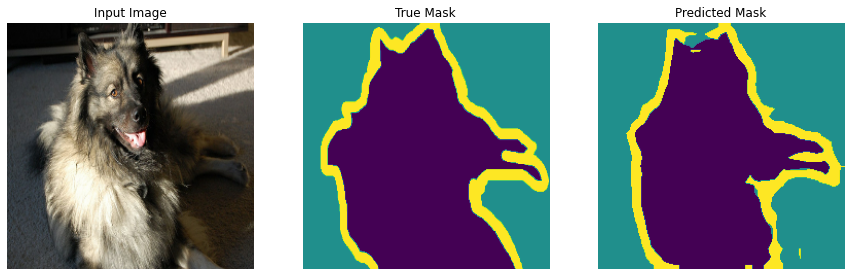

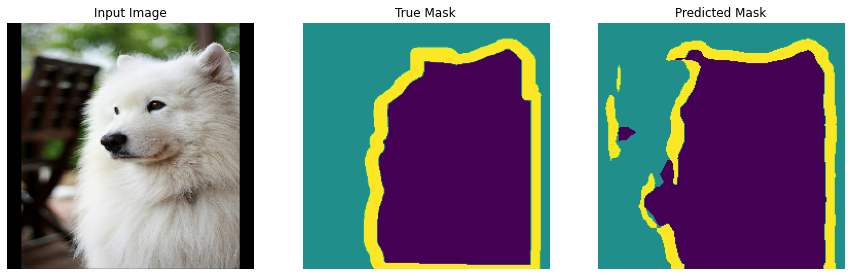

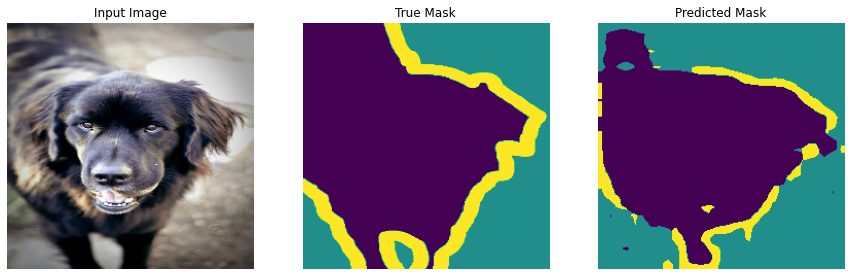

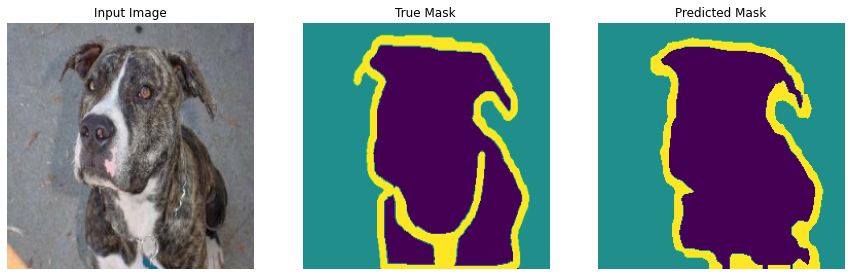

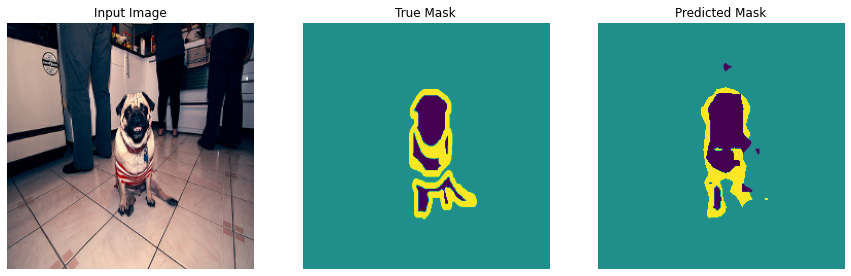

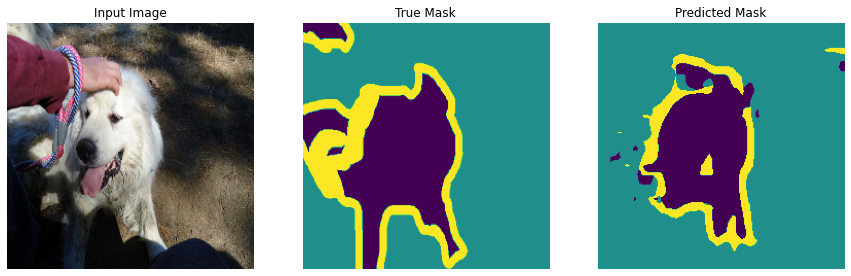

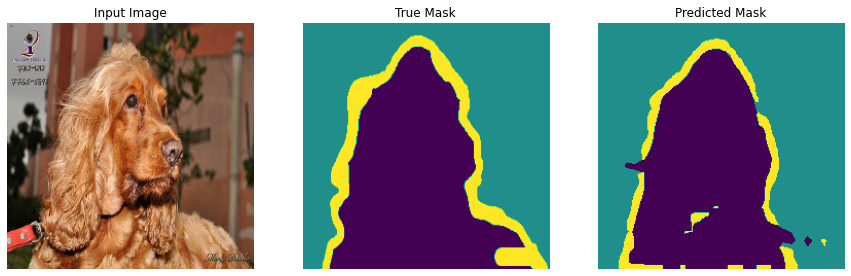

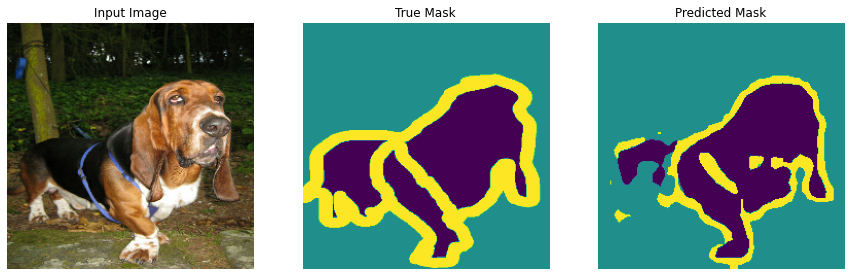

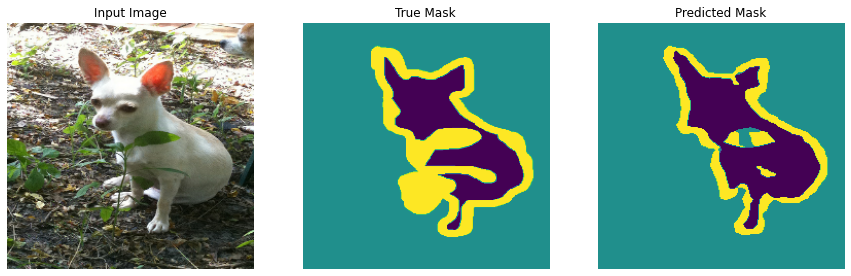

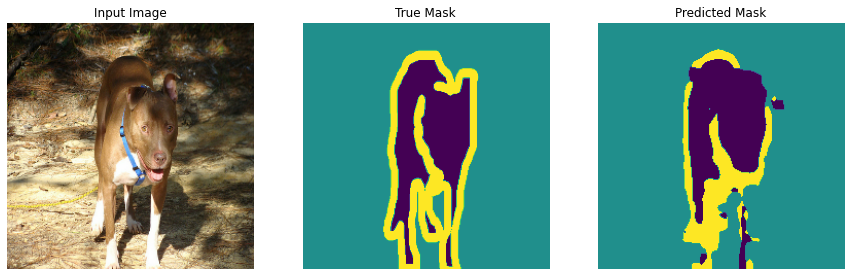

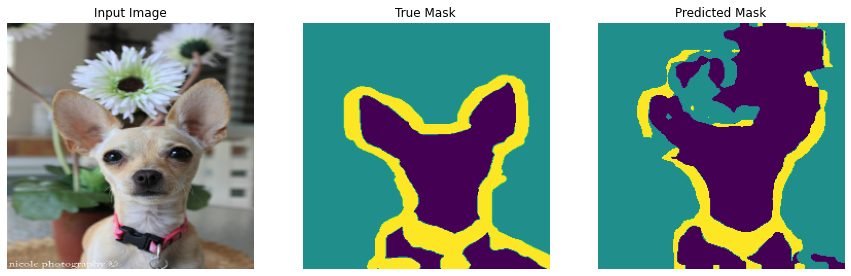

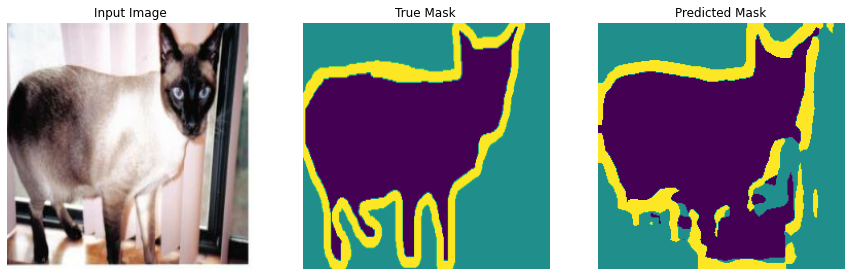

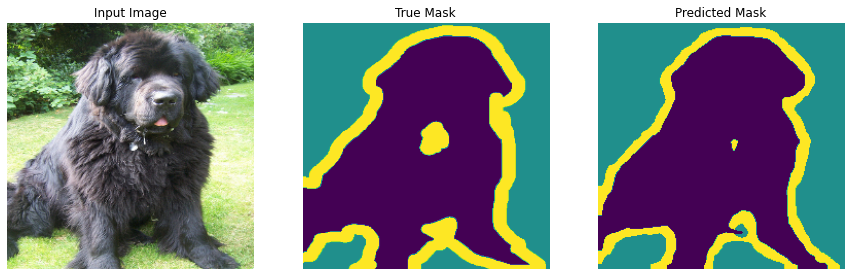

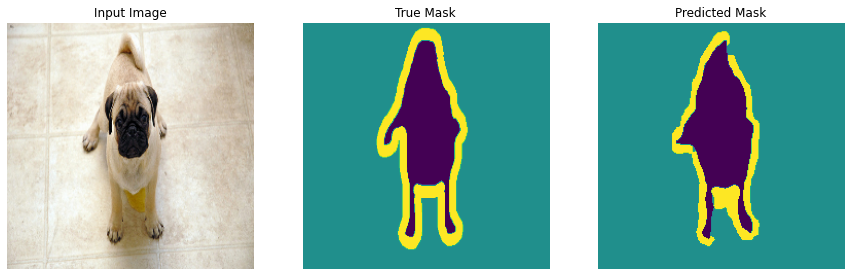

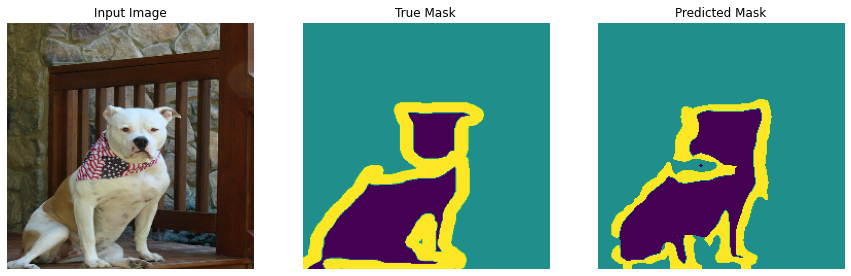

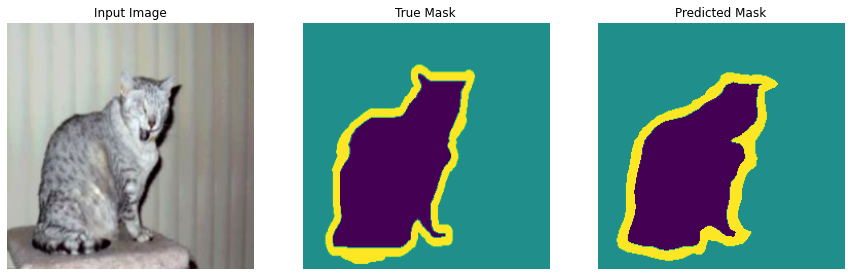

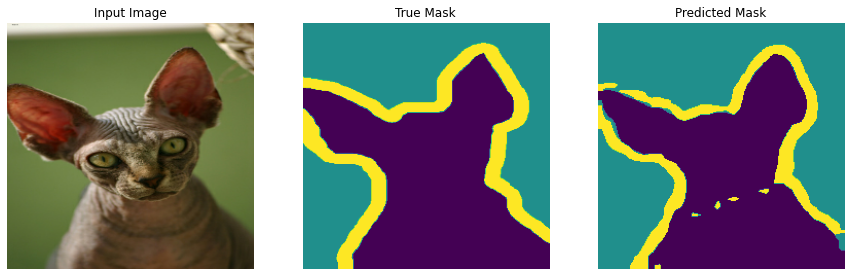

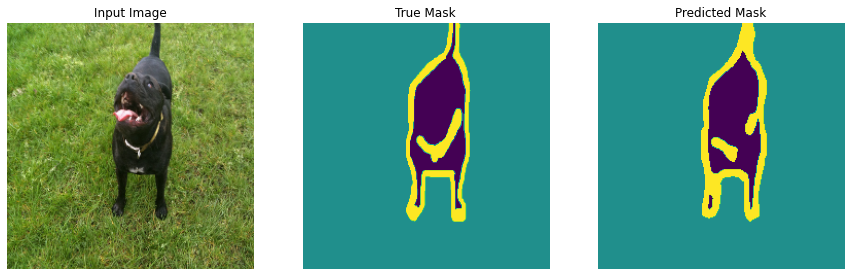

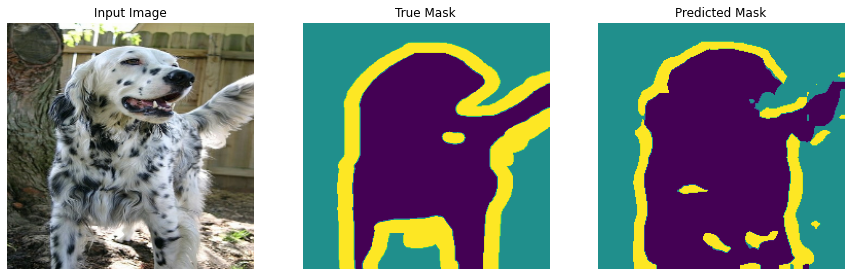

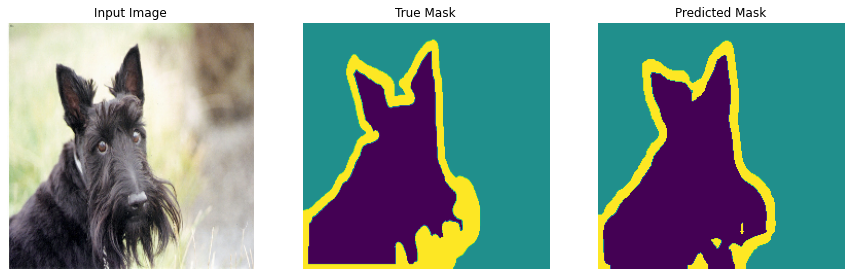

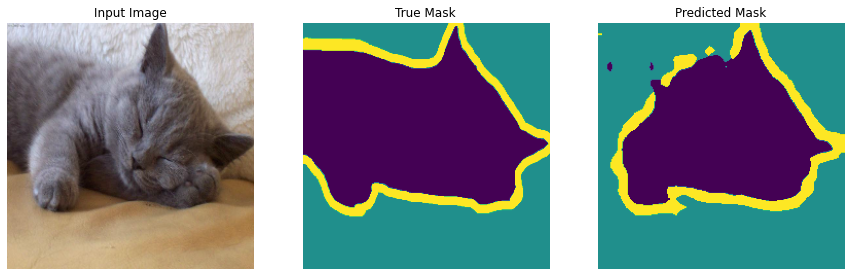

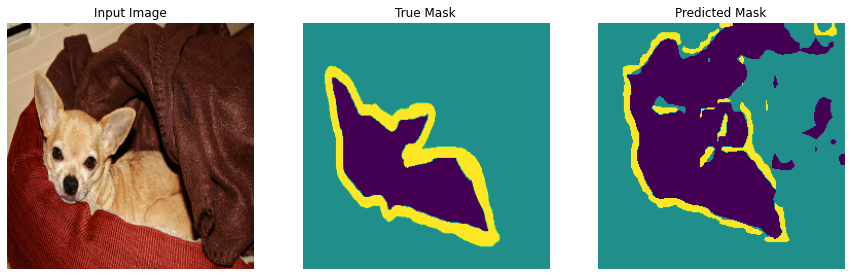

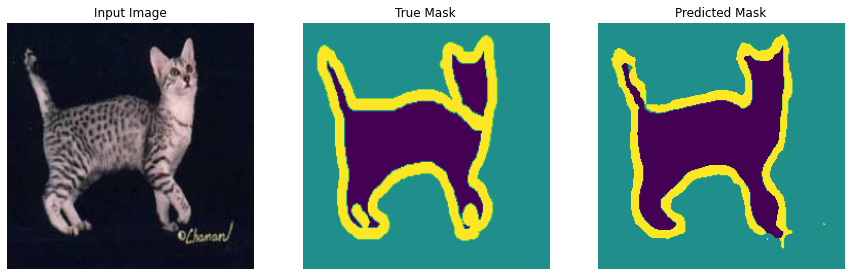

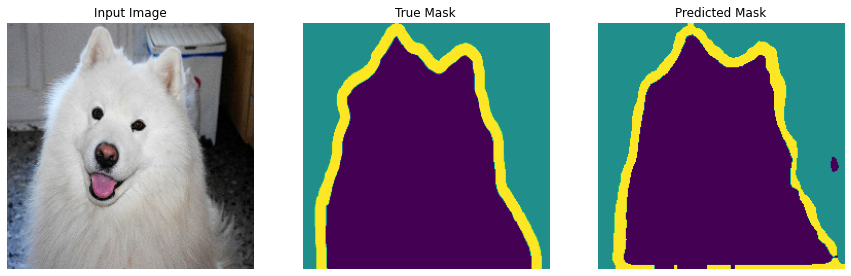

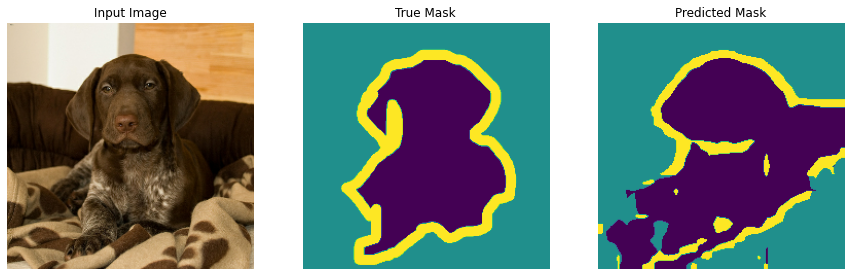

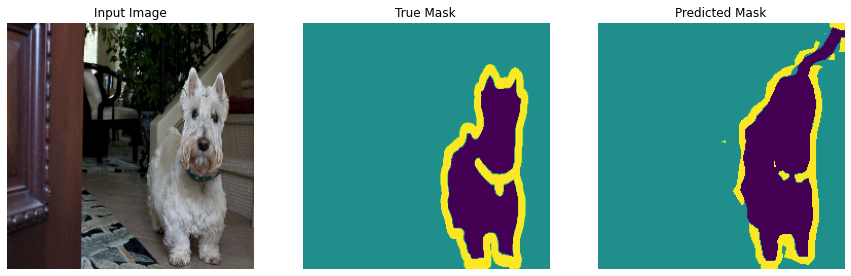

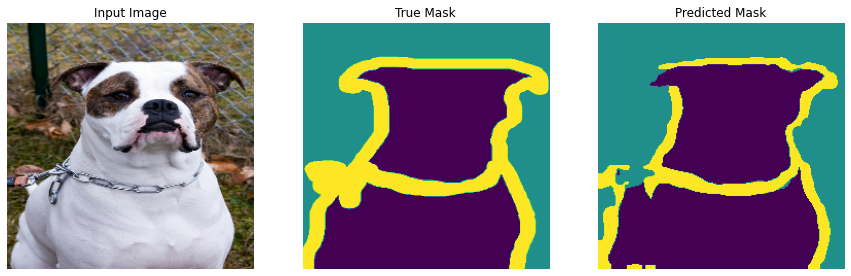

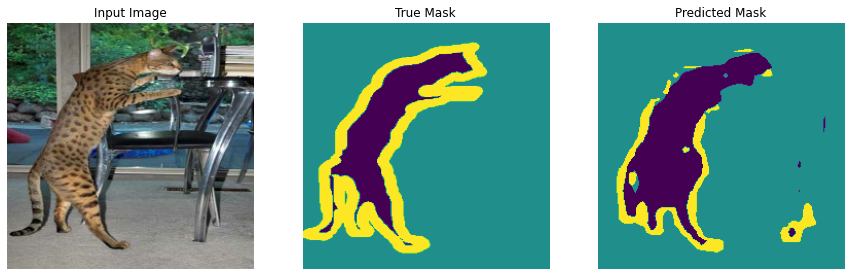

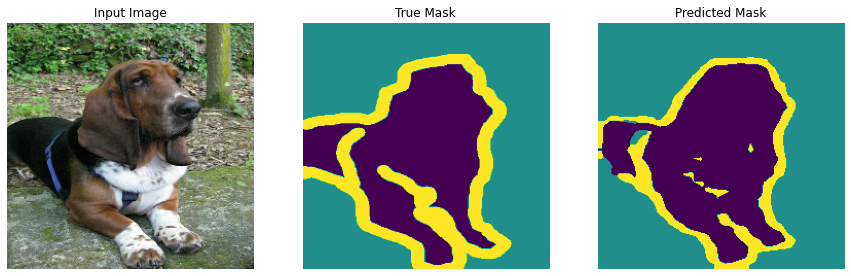

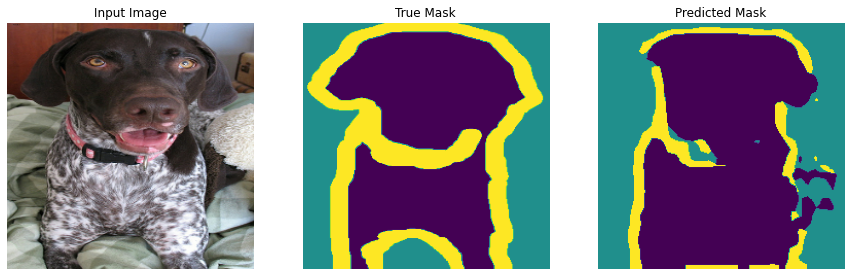

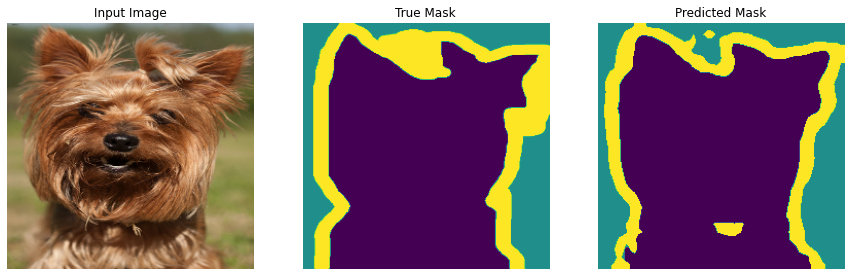

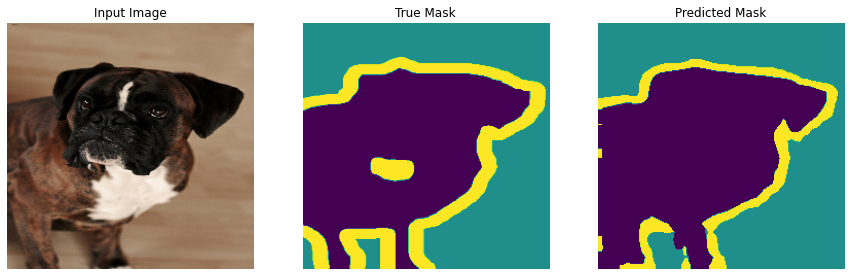

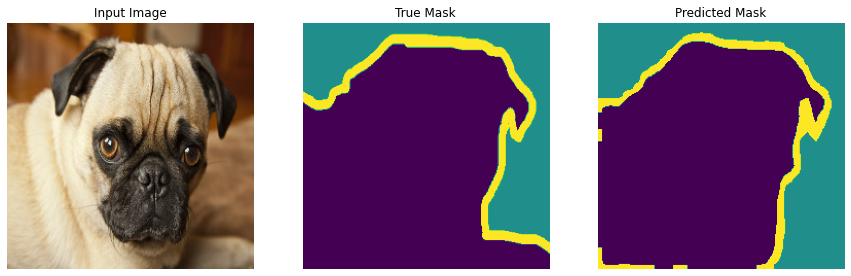

In [15]:
show_predictions(test_dataset, 40)